Advanced Lane Finding 

PROJECT RUBRIC  - CAMERA CALIBRATION
-----------------------------------------

 Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

In [9]:
#CELL # 1 
############
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [10]:
#CELL # 2
############

# Define empty list  
objpoints = [] # 3D points
imgpoints = [] # 2D points (converted)

# Read calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Initialize object points - 6 * 9 because there are 6 corners on y axis
# and 9 corners on x-axis
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)



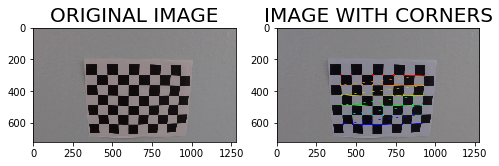

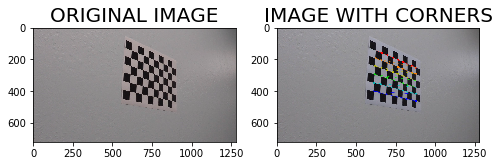

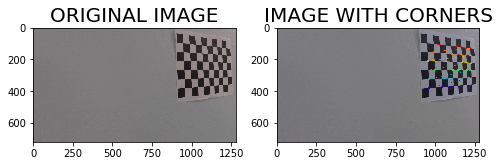

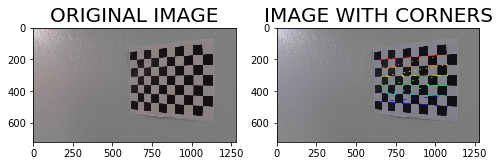

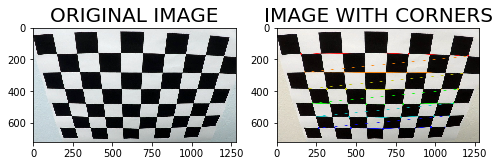

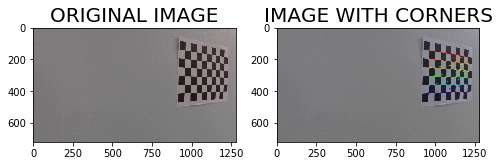

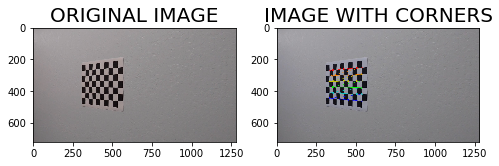

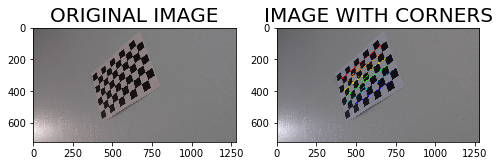

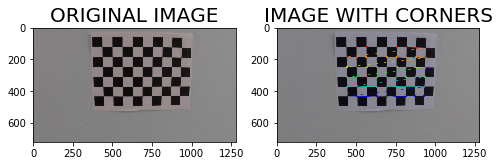

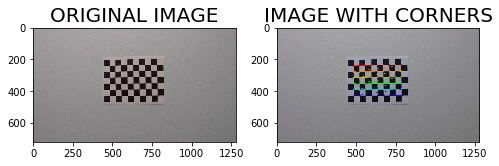

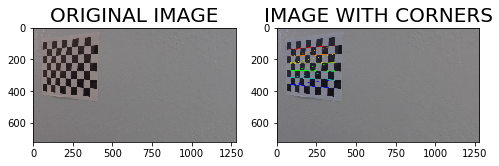

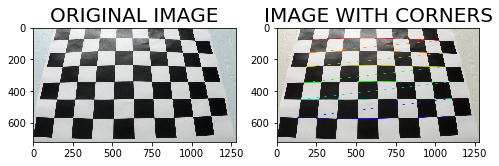

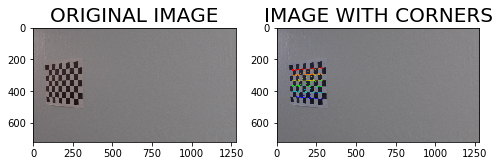

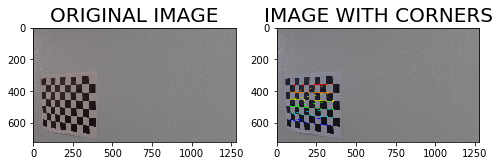

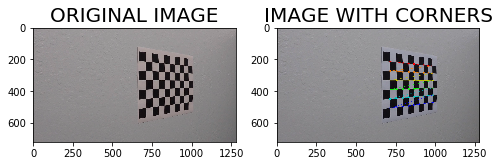

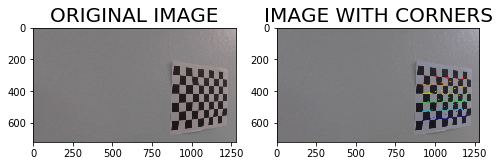

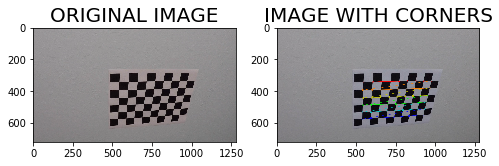

In [11]:
#CELL # 3
############

# Iterate through all images and convert them to GRAY format
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find Chess corners , ret being boolean 
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found , i.e. ret==True , add c objpoints - 3D
    # and imgpoints - 2D
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (a, b) = plt.subplots(1, 2, figsize=(8,4))
        a.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        a.set_title('ORIGINAL IMAGE', fontsize=20)
        b.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        b.set_title('IMAGE WITH CORNERS', fontsize=20)

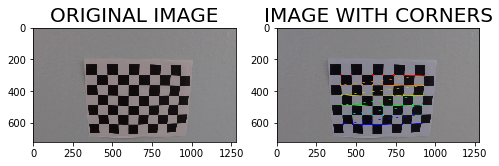

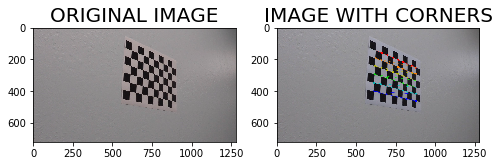

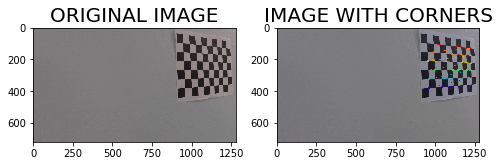

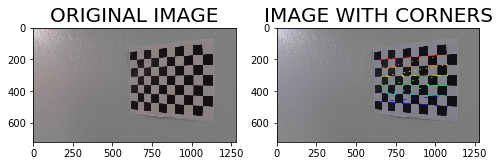

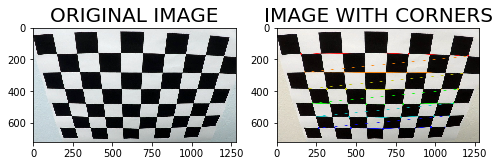

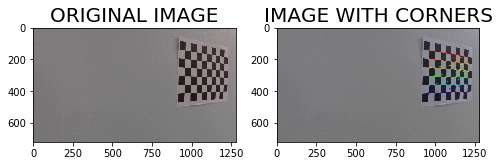

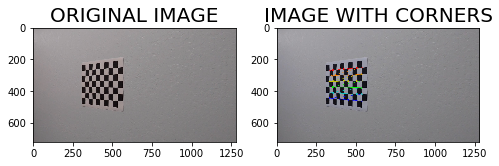

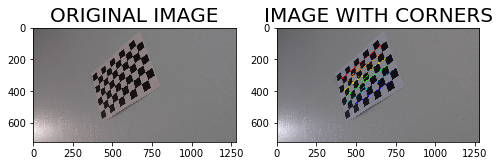

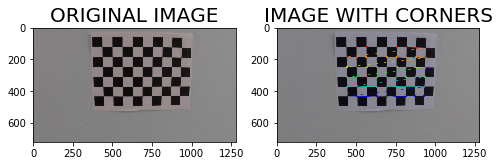

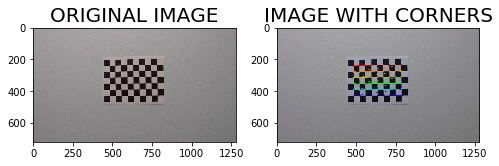

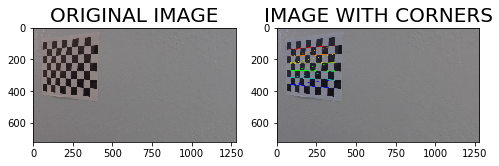

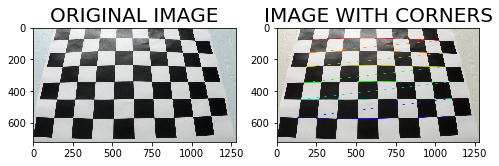

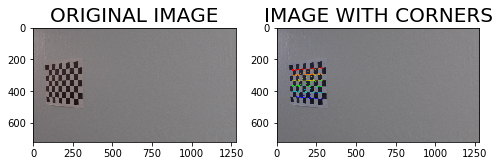

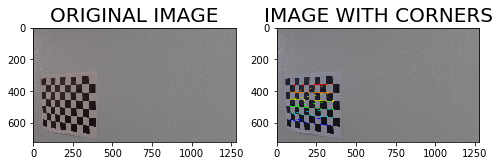

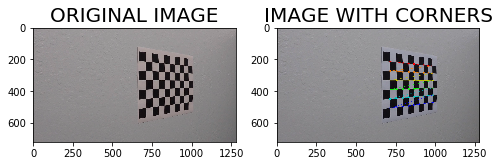

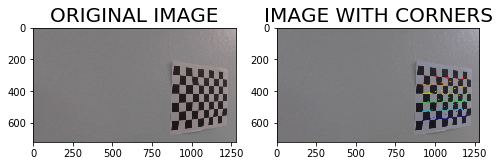

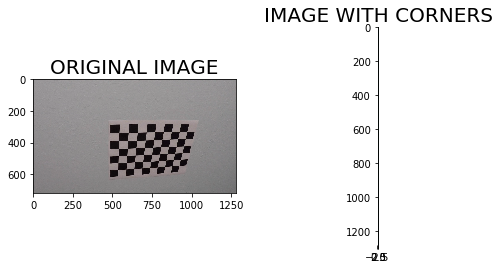

In [36]:
#CELL # 4
############

# Display some images
plt.imshow(img[1])
plt.show()

PROJECT RUBRIC # 2 : UNDISTORTED IMAGES
----------------------------------------

Provide an example of a distortion-corrected image.

In [12]:
#CELL # 5
############

# Define a function for Camera Calibration and Undistort images 
def cal_undistort(image):
    img = cv2.imread(image) # Read image
    img_size = (img.shape[1], img.shape[0]) # Find its shape
    offset = 0
    # Find camera matrix , distortion , rotation and translation vector
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Call undistort function (it is taking matrix and distortion as input)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    

    return undist

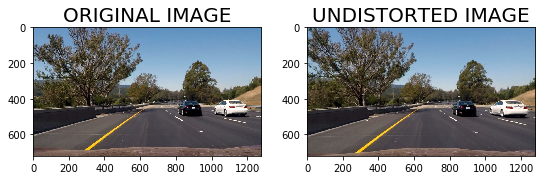

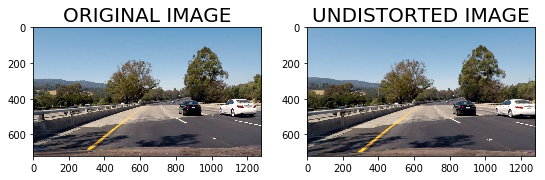

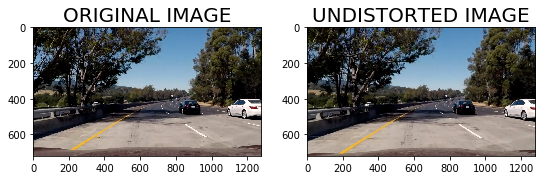

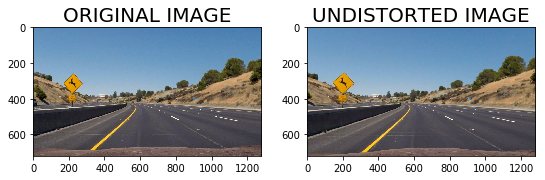

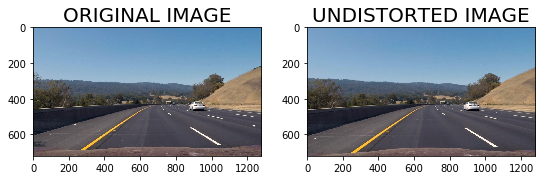

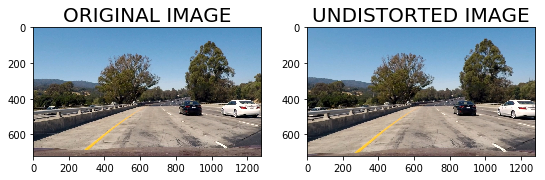

In [48]:
#CELL # 6
############

images = glob.glob('test_images/test*.jpg')
for image in images:
    img = cv2.imread(image)
    f, (a, b) = plt.subplots(1, 2, figsize=(9,6))
    a.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    a.set_title('ORIGINAL IMAGE', fontsize=20)
    undist = cal_undistort(image)
    b.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    b.set_title('UNDISTORTED IMAGE', fontsize=20) 
    plt.show()
    

PROJECT RUBRIC : PERSPECTIVE TRANSFORM
---------------------------------------
Describe how (and identify where in your code) you performed a perspective transform and
provide an example of a transformed image.

In [13]:
#CELL # 7
############

# Perspective Transform

def cal_perspect_transform(img) :
    
    undist = cal_undistort(img)
    img_size = (undist.shape[1], undist.shape[0])
    
    src = np.float32([[450, 490],[820, 490],
                      [1280, 740],[50, 740]])
    dst = np.float32([[0, 0], [1270, 0], 
                     [1280, 740],[40, 740]])
    
    # Calculate Perspective Transform Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Warped image using Perspective Transform Matrix calculated in above step 
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M



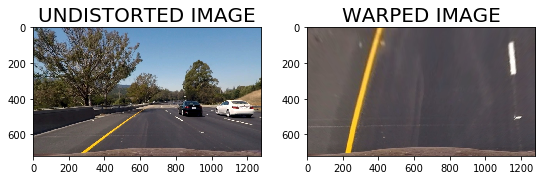

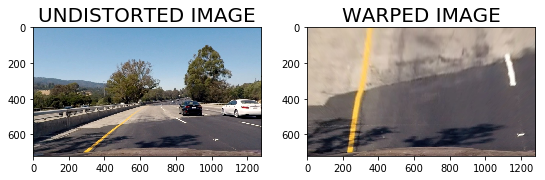

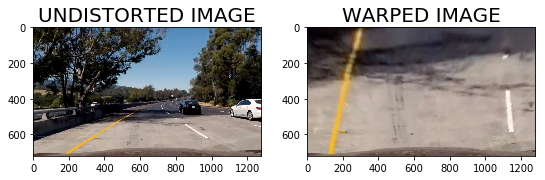

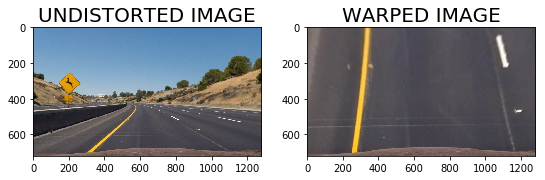

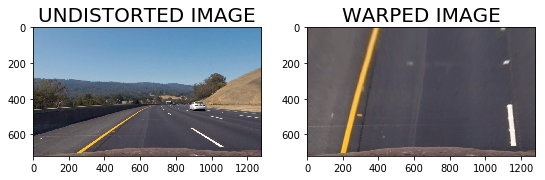

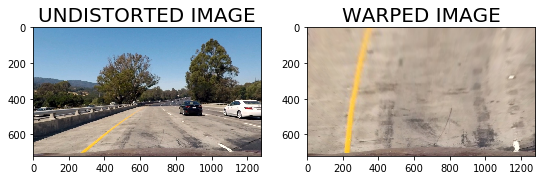

In [59]:
#CELL # 8
############

images = glob.glob('test_images/test*.jpg')

for image in images:
    
    undist = cal_undistort(image)
    f, (a, b) = plt.subplots(1, 2, figsize=(9,6))

    a.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    a.set_title('UNDISTORTED IMAGE', fontsize=20) 
    
    
    undist_pers , M = cal_perspect_transform(image)
    
    b.imshow(cv2.cvtColor(undist_pers, cv2.COLOR_BGR2RGB))
    b.set_title('WARPED IMAGE', fontsize=20) 
    
    plt.show()

PROJECT RUBRIC : COLOR AND GRADIENT COMBINED
----------------------------------------------
Describe how (and identify where in your code) you used color transforms, gradients or other methods
to create a thresholded binary image. Provide an example of a binary image result.

In [14]:
#CELL # 9
############

# Calculate color and gradient thresholds 
def combine_col_grad(image):
    img, M = cal_perspect_transform(image)

    # Seperate h , l and s color channel
    
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    
    L = hls[:,:,1]
    
    S = hls[:,:,2]
    
    h_thresh_min = 140
    h_thresh_max = 200
    # Convert H (Hue) channel to binary format
    h_binary = np.zeros_like(H)
    h_binary[(H >= h_thresh_min) & (H <= h_thresh_max)] = 1
    
    
    l_thresh_min = 160
    l_thresh_max = 255
    # Convert L (Luminosity) channel to binary format
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh_min) & (L <= l_thresh_max)] = 1
    
    s_thresh_min = 200
    s_thresh_max = 255
    # Convert S (Saturation) channel to binary format
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh_min) & (S <= s_thresh_max)] = 1
    
    
    # Convert image to gray color
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sx_thresh_min = 20
    sx_thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh_min) & (scaled_sobel <= sx_thresh_max)] = 1


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, S))

    return h_binary , l_binary , s_binary , color_binary    

    

    


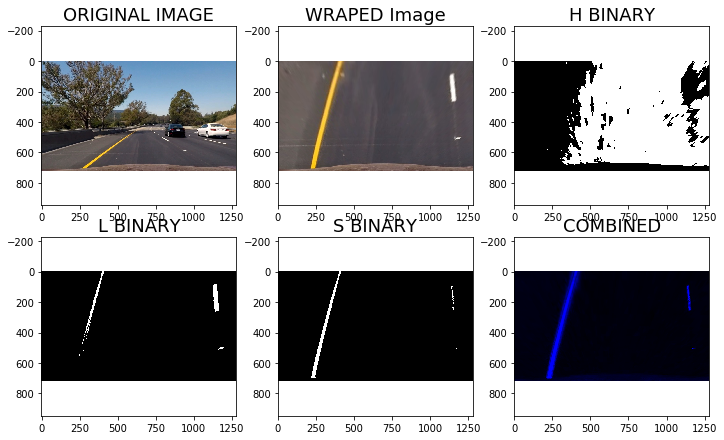

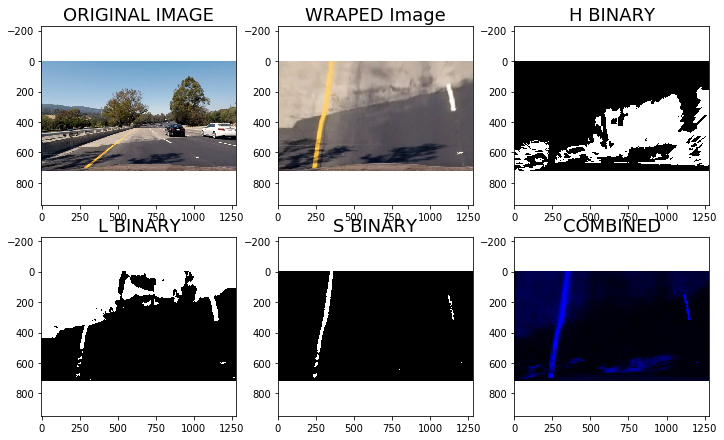

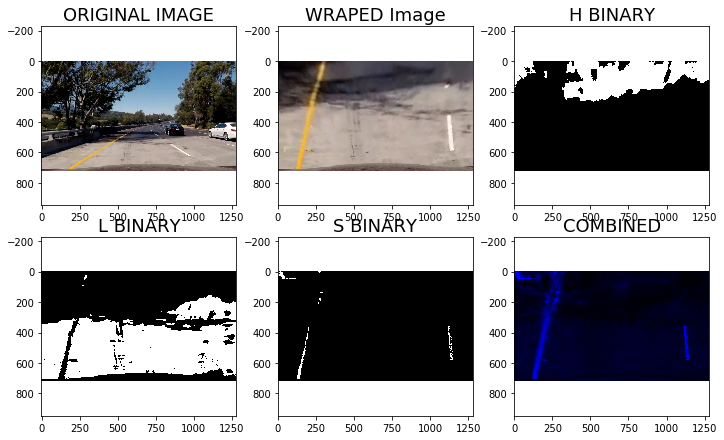

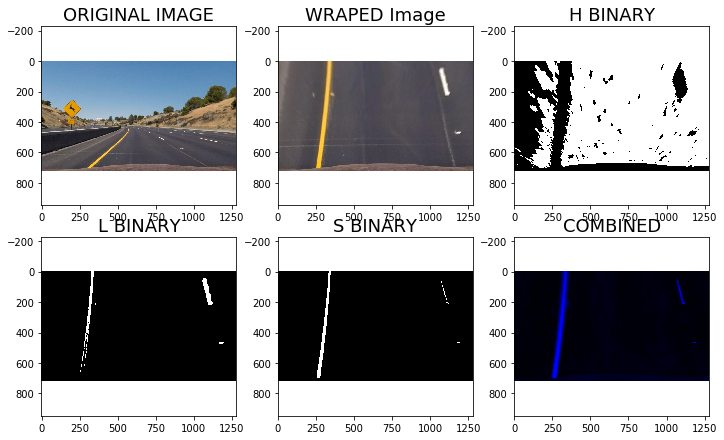

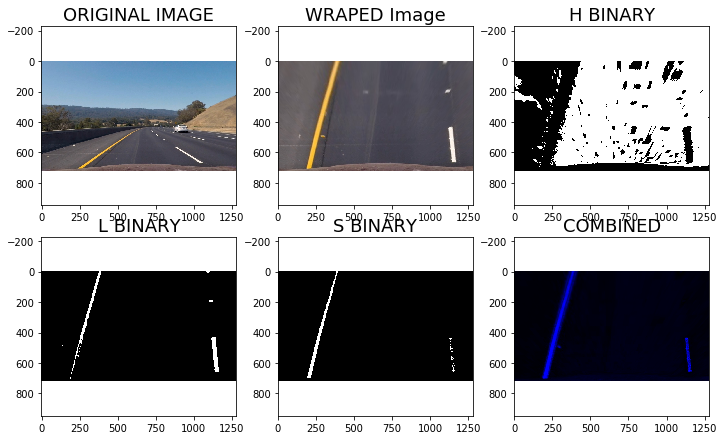

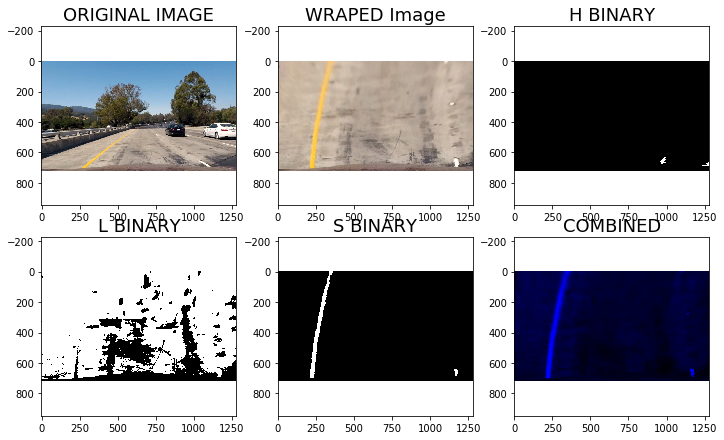

In [66]:
#CELL # 10
############

images = glob.glob('test_images/test*.jpg')

for image in images:
    plot_h_binary , plot_l_binary , plot_s_binary , plot_color_binary   = combine_col_grad(image)
    
    plot_wraped , M = cal_perspect_transform(image)
    
    # Plotting thresholded images
    f, ((a1, a2, a3), (a4, a5 , a6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,6))
    f.tight_layout()
        
    a1.set_title('ORIGINAL IMAGE', fontsize=18)
    a1.imshow(cv2.cvtColor(cal_undistort(image),cv2.COLOR_BGR2RGB))
        
    a2.set_title('WRAPED Image', fontsize=18)
    a2.imshow(cv2.cvtColor(plot_wraped, cv2.COLOR_BGR2RGB).astype('uint8'))
        
    a3.set_title('H BINARY', fontsize=18)
    a3.imshow(plot_h_binary, cmap='gray')
        
    a4.set_title('L BINARY', fontsize=18)
    a4.imshow(plot_l_binary, cmap='gray')
        
    a5.set_title('S BINARY', fontsize=18)
    a5.imshow(plot_s_binary, cmap='gray')

    a6.set_title('COMBINED', fontsize=18)
    a6.imshow(plot_color_binary, cmap='gray')

    plt.show()
       
    
    

In [15]:
#CELL # 11
############

# Create binary thresholded images to isolate lane line pixels
def cal_threshold(image):
    img, M = cal_perspect_transform(image)

    
    
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    B = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 
    

    # Threshold color channel
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(B)
    b_binary[(B >= b_thresh_min) & (B <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh_min) & (L <= l_thresh_max)] = 1

    
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return combined_binary


In [16]:
#CELL # 12
############

def detect_lane(image):
    
    combined_binary = cal_threshold(image)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    
    
    # i , j - to loop through 
    i = 900
    j = 800
    while j >= 0:
        
        # Take histogram of the image taken as output of combined 
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        
        
        # Identify the left peak of the historgam
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        # Identify the right peak of the histogram   
        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i = i - 100
        j = j - 100

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    # Fit a second order polynomial to left lane and right lane

    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2] 
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2] 
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]  
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    #Define conversions in x & y from pixels space to meters 
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print (left_curverad, 'm', right_curverad, 'm')
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    
    
    
    img_size = (img.shape[1], img.shape[0])
    
    # Define source and destination so as to generate a perspective transform
    src = np.float32([[490, 480],[800, 480],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    # Generate Inverse Perspective transform using opencv function getPerspectiveTransform
    # takinng source and destination co-ordinates from previous step
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create an image to draw the lines 
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped  image   
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 50)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.4, 0)
    
    f, (a1, a2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    
    
    # Plot the image - original image with lane line with polynomial
    a1.imshow(cv2.cvtColor((cal_perspect_transform(image)[0]), cv2.COLOR_BGR2RGB))
    a1.set_xlim(0, 1280)
    a1.set_ylim(0, 720)
    a1.plot(left_fitx, lefty, color='red', linewidth=5)
    a1.plot(right_fitx, righty, color='red', linewidth=5)
    a1.set_title('Fit Polynomial to Lane Lines', fontsize=18)
    a1.invert_yaxis() # to visualize as we do the images
    
    # Plot te image - Final images 
    a2.imshow(result)
    a2.set_title('Fill Lane', fontsize=18)
    if center < 640:
        a2.text(50, 100, '{:.2f}m left of center'.format(center*3.7/700),
                 style='oblique', color='white', fontsize=12)
    else:
        a2.text(50, 100, '{:.2f}m right of center'.format(center*3.7/700),
                 style='oblique', color='white', fontsize=12)
    a2.text(50, 155, 'Curvature Radius =  {}m'.format(int((left_curverad + right_curverad)/2)),
             style='oblique', color='white', fontsize=12)
    plt.show()


2141.1275652 m 3471.96948331 m


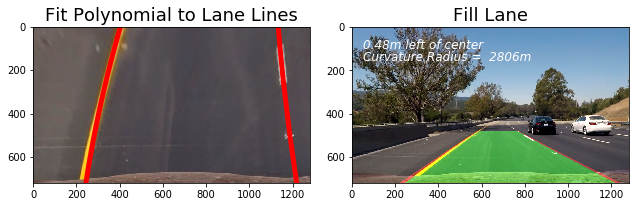

8374.90589428 m 1850.88235668 m


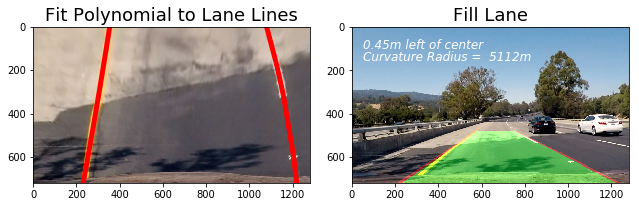

2118.59424902 m 3846.46467608 m


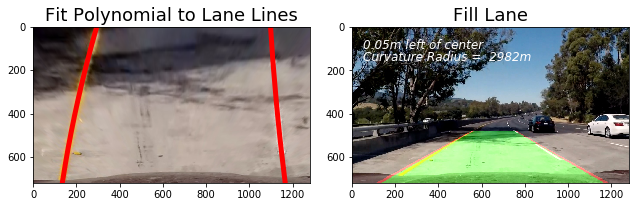

6539.55288423 m 2439.85806666 m


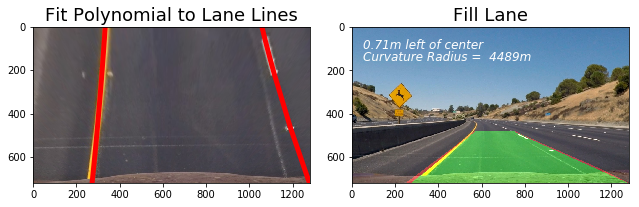

3630.34312717 m 5200.31692677 m


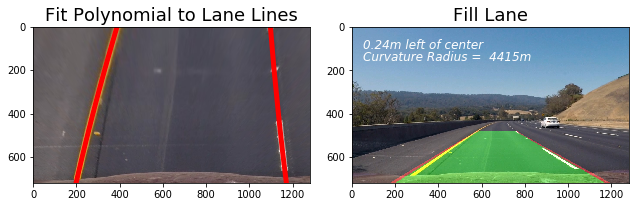

1782.68753839 m 2150.70685873 m


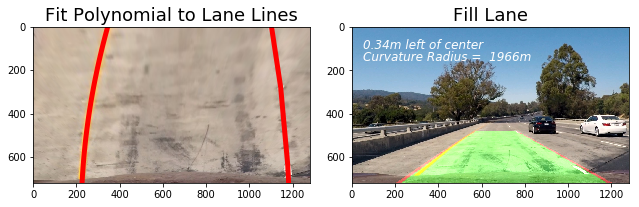

In [17]:
#CELL # 13
############
images = glob.glob('test_images/test*.jpg')

for image in images:
    detect_lane(image)

In [18]:
#CELL # 14
############
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.found = False
        
        # X value from last frame
        self.X = None
        
        # Y value from last frame
        self.Y = None
                
        # Store Recent x intercepts 
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Store recent intercept to compare with the current one.
        self.lastx_int = None
        self.last_top = None
        
        # Store radius of curvature
        self.radius = None
        
        # Store polynomial coefficents
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Store count of number of frames
        self.count = 0
    
    
    
    # Function to calculate radius of curvature to be displayed on video top (left side) after calculation . 
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def calculate_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]

        return bottom, top
    
    def cal_sorting(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    
    # Function to detect lane pixels in close proximity       
    def search_close_pixel(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            i = 900
            j = 800
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i = i - 100
                j = j - 100
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    # Function to do sliding window search to detect peaks in historgam . 
    
    def sliding_win_search(self, x, y, image):
        xvals = []
        yvals = []
        if self.found == False: 
            i = 900
            j = 800
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i = i - 100
                j = j - 100
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    




In [19]:
#CELL # 15
############

from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

###############################################
# Steps followed
# 1. Do camera calibartion 
# 2. Find Undistort Image
# 3. Find perspective transform 
# 4. Find lane lines 
# 5. Do sliding window search 
# 6. Find radius of curvature
# 7. Find the position of vehicle
# 8. Calculate inverse perspective transform 
# 9. Plot the lane lines and warped image
# 10. Combine the result with orignial image
###############################################

def video_pipeline(image):
    
    # Find image size f- to be used for undistortion and camera calibration 
    img_size = (image.shape[1], image.shape[0])
    
    # Find camera matrix , distortion , rotation and translation vector
    offset = 0
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Call undistort function (it is taking matrix and distortion as input)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
        
    # Identify source and destination points so as to perform perspective transform of lanes
    src = np.float32([[490, 480],[800, 480],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    
    # Find Perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Perform Perspective transform using matrix M on undistorted image
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate threshold images
    B = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    L = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Define threshold for B channel and do binary transform 
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(B)
    b_binary[(B >= b_thresh_min) & (B <= b_thresh_max)] = 1
    
    # Define threshold for L channel and do binary transform
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh_min) & (L <= l_thresh_max)] = 1

    stack_binary = np.zeros_like(b_binary)
    stack_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify non-zero pixels 
    x, y = np.nonzero(np.transpose(stack_binary)) 


    if Left.found == True:
        leftx, lefty, Left.found = Left.search_close_pixel(x, y)
        Right.found
    if Right.found == True: 
        rightx, righty, Right.found = Right.search_close_pixel(x, y)

    # Perform search on right lane            
    if Right.found == False: 
        rightx, righty, Right.found = Right.sliding_win_search(x, y, stack_binary)
            
    # Perform search on left lane
    if Left.found == False:
        leftx, lefty, Left.found = Left.sliding_win_search(x, y, stack_binary)
    
    # Append detected pixels - left 
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    
    # Append detected pixels - right
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Find polynomial fit - left lane
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts - left lane
    leftx_int, left_top = Left.calculate_intercepts(left_fit)
    
    #Find average of intercepts across frame
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    
    # Add average intercepts 
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on values of y 
    leftx, lefty = Left.cal_sorting(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Calculate polynomial again with intercepts and average it across frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), np.mean(Left.fit1), np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Find polynomial fit - right lane
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts - left lane
    
    rightx_int, right_top = Right.calculate_intercepts(right_fit)
    
    # Find average of intercepts across frame
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    
    # Add averaege intercepts
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort detected pixels 
    rightx, righty = Right.cal_sorting(rightx, righty)
    
    Right.X = rightx
    Right.Y = righty
    
    # Calculate polynomial again with intercepts and average it across frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Find radius of curvature
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Print radius of curvature every 5 frames 
    if Left.count % 5 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Find position of the vehicle - to be displayed in video 
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    
    # Generate Inverse Perspective transform using opencv function getPerspectiveTransform
    # takinng source and destination co-ordinates initialized above
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(stack_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped  image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 50)
    cv2.fillPoly(color_warp, np.int_(pts), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
   # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle = {:.2f}m left of center'.format(distance_from_center), (50,80),
                 fontFace = 16 , fontScale = 1, color=(255,255,255), thickness = 1)
    else:
        cv2.putText(result, 'Vehicle = {:.2f}m right of center'.format(distance_from_center), (50,80),
                 fontFace = 16 , fontScale = 1, color=(255,255,255), thickness = 1)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature = {} meter'.format(int((Left.radius+Right.radius)/2)), (80,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    Left.count += 1
    return result

In [20]:
#CELL # 16 
############

# Final output 

# Initialize : Class "Line" 
Left = Line()  
Right = Line() 

# Call video_pipeline function 
video_output = 'Output_P4_Video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video Output_P4_Video.mp4
[MoviePy] Writing video Output_P4_Video.mp4


100%|█████████▉| 1260/1261 [28:30<00:02,  2.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_P4_Video.mp4 

